In [62]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline



In [221]:
# G = scipy.signal.lti([1], [15, 8, 1])
# continuous dynamics
# 2 x 2
A = np.array([
    [0, 1.0],
    [0, 0.0]
])
# 2 x 1
B = np.array([
    [0], 
    [1.0]
])
# 1 x 2
C = np.array([[1, 0.0]])
D = np.array([[0.0]])
G = scipy.signal.StateSpace(A, B, C, D)
n = 2
m = 1
x = np.ones((n, 1))
u = np.ones((m, 1))

In [222]:
print((A @ x).shape)
print((B @ u).shape)
print((C @ x).shape)
print((D @ u).shape)

(2, 1)
(2, 1)
(1, 1)
(1, 1)


In [223]:
G


StateSpaceContinuous(
array([[0., 1.],
       [0., 0.]]),
array([[0.],
       [1.]]),
array([[1., 0.]]),
array([[0.]]),
dt: None
)

In [207]:
# plt.plot()
# G.step()[1]


In [224]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 1  # Sampling rate

In [225]:
tcontinuous = np.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = np.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizo

In [226]:
tpredict

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [227]:
tau_c = 1
r = 1 - np.exp(-tpredict/tau_c)

In [249]:
u = np.ones((M, m))
u_extra = np.repeat(u[-1, :].reshape(1,m), P-M, axis=0)
# u[:, -1].reshape(3,1)

In [250]:
np.vstack([u, u_extra])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [230]:
x0 = np.zeros(G.to_ss().A.shape[0])



In [243]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    u_repeat = np.repeat(u[-1, :].reshape(1,m), P-M, axis=0)
    return np.vstack([u, u_repeat])

In [244]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, x0)
    return x

In [245]:
prediction(extend(u))

array([[  0. ,   0. ],
       [  0.5,   1. ],
       [  2. ,   2. ],
       [  4.5,   3. ],
       [  8. ,   4. ],
       [ 12.5,   5. ],
       [ 18. ,   6. ],
       [ 24.5,   7. ],
       [ 32. ,   8. ],
       [ 40.5,   9. ],
       [ 50. ,  10. ],
       [ 60.5,  11. ],
       [ 72. ,  12. ],
       [ 84.5,  13. ],
       [ 98. ,  14. ],
       [112.5,  15. ],
       [128. ,  16. ],
       [144.5,  17. ],
       [162. ,  18. ],
       [180.5,  19. ]])

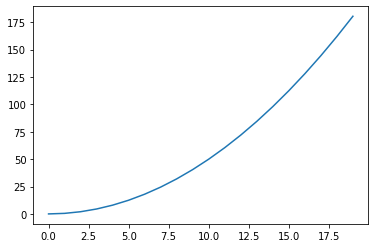

In [273]:
plt.plot(tpredict, prediction(extend(u))[:,0])

In [264]:
def objective(u, x0=x0):
    u = u.reshape((M, m))
    x = prediction(extend(u))
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = np.sum(np.abs(np.diff(u)))
    strongfinish = np.abs(x[-1, 0] - r[-1])
    return sum((r - x[:, 0])**2) + 0.1*constraintpenalty + 0.1*movepenalty + 0*strongfinish



In [268]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x.reshape((M, m))
result.fun

0.01687040356173669

In [269]:
uopt

array([[ 1.98646136e+00],
       [-6.08143241e-01],
       [-5.75774768e-01],
       [ 2.94618202e-01],
       [-1.04610829e-02],
       [-1.51729668e-01],
       [ 2.87236022e-02],
       [ 7.20739642e-02],
       [-4.53180144e-02],
       [ 4.46816063e-04]])

In [270]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]

In [276]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
#     plt.plot(tcontinuous, prediction(ucont, tcontinuous)[:,0], label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt))[:,0], '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()

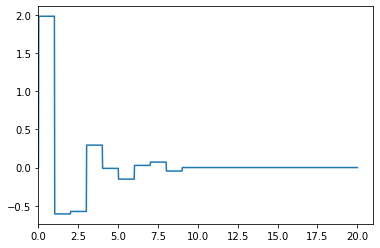

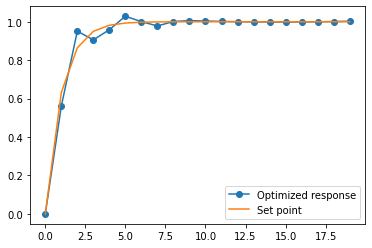

In [277]:
plotoutput(ucont, uopt)